<a href="https://colab.research.google.com/github/zoegarm/Clasificacion-de-imagenes-de-satelite/blob/main/Prototype_Santander_BEDU_jalisco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # **Clasificación de imágenes de satélite**

### Data Science: Equipo 2

## **Introducción**

Nuestro proyecto se basa en la utilización de diferentes métodos de clasificación de imágenes de satélite, verificando qué método es el más óptimo de acuerdo al tiempo de cómputo y su precisión, en una arena de clasificadores. 

La libreta contiene datos del estado de Jalisco, las imágenes de satélite se descargaron del [siguiente repositorio](https://earthexplorer.usgs.gov/).

En este caso, las imágenes del satélite Landsat 8 en valores de reflectancia del terreno, con resolución de 30 metros y correspondientes parte de la zona metropolitana de Guadalajara, en el estado de Jalisco, México. La siguiente tabla presenta una descripción general de los datos.


| | |
| --- | --- |
| Satélite | Landsat 8 |
| Fecha de adquisición | 20-03-2018 |
| Altura | 1328  |
| Anchura | 643   |
| # de Bandas | 7 |
| Resolución espacial | 30 metros | 




## **I. Librerías y datos**

Para iniciar nuestra libreta vamos a llamar las primeras librerías de python, las cuales las usaremos para cargar nuestros datos, visualizar las imágenes, etc.

Es importante instalar **rasterio** para poder accesar y trabajar con los datos no estruturados de las imágenes de sátelite sin complicaciones.

In [1]:
!pip install rasterio

     |████████████████████████████████| 19.3MB 1.4MB/s 


In [142]:
# Importar pandas para dataframes
import pandas as pd

#importamos la función time de la librería time para reportar el tiempo de ejecución
from time import time

# Importar librerías numéricas
import numpy as np

# Importar las dependencias usadas para el uso de imágenes de satélite 
import rasterio as rio

# Importar las librerías de graficación
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from rasterio.plot import show
import folium

In [3]:
# Importamos los datos desde Github
Landsat_data = []
for i in range(1,8):
    Landsat_data.append(f"https://github.com/zoegarm/Clasificacion-de-imagenes-de-satelite/blob/main/images_sat/jalisco_B{i}.tif?raw=true")


# Acomodamos los datos en orden de las bandas
Landsat_data.sort()

# Visualizamos el path de los archivos
Landsat_data

['https://github.com/zoegarm/Clasificacion-de-imagenes-de-satelite/blob/main/images_sat/jalisco_B1.tif?raw=true',
 'https://github.com/zoegarm/Clasificacion-de-imagenes-de-satelite/blob/main/images_sat/jalisco_B2.tif?raw=true',
 'https://github.com/zoegarm/Clasificacion-de-imagenes-de-satelite/blob/main/images_sat/jalisco_B3.tif?raw=true',
 'https://github.com/zoegarm/Clasificacion-de-imagenes-de-satelite/blob/main/images_sat/jalisco_B4.tif?raw=true',
 'https://github.com/zoegarm/Clasificacion-de-imagenes-de-satelite/blob/main/images_sat/jalisco_B5.tif?raw=true',
 'https://github.com/zoegarm/Clasificacion-de-imagenes-de-satelite/blob/main/images_sat/jalisco_B6.tif?raw=true',
 'https://github.com/zoegarm/Clasificacion-de-imagenes-de-satelite/blob/main/images_sat/jalisco_B7.tif?raw=true']

In [4]:
# Mapa definiendo el area de esutdio usando folium

m = folium.Map(location=[20.45, -103.2], zoom_start=10, width="100%", height='100%')
area_study = "https://raw.githubusercontent.com/zoegarm/Clasificacion-de-imagenes-de-satelite/main/images_sat/area_estudio.geojson"
folium.GeoJson(area_study, name="geojson").add_to(m)
m

## **II. Preprocesamiento de imágenes y análisis exploratorio de datos**

A continuación realizamos la integración de las 7 bandas que componen la fotografía satelital final y mostramos dichas imágenes. Asimismo, presentamos el análisis exploratorio de estos datos con histogramas y boxplots.


In [5]:
# Realizamos un array con las 7 imágenes

imagenes = []
labels = []
for i in range(0,len(Landsat_data)):
  print(f"La banda {Landsat_data[i][-15:-13]}, está almacenada en la posición {[i]} del array")
  labels.append(Landsat_data[i][-15:-13])
  with rio.open(Landsat_data[i], 'r') as d:
    imagenes.append(d.read(1))

arr_img = np.stack(imagenes)
arr_img = np.moveaxis(arr_img, 0, -1)

# Ahora vamos a verificar el arreglo de nuestro array

print(f"La dimensión de nuestro array es:\n {arr_img.shape[2]} bandas (o canales)\n {arr_img.shape[0]} alto\n {arr_img.shape[1]} ancho")

La banda B1, está almacenada en la posición [0] del array
La banda B2, está almacenada en la posición [1] del array
La banda B3, está almacenada en la posición [2] del array
La banda B4, está almacenada en la posición [3] del array
La banda B5, está almacenada en la posición [4] del array
La banda B6, está almacenada en la posición [5] del array
La banda B7, está almacenada en la posición [6] del array
La dimensión de nuestro array es:
 7 bandas (o canales)
 1328 alto
 643 ancho


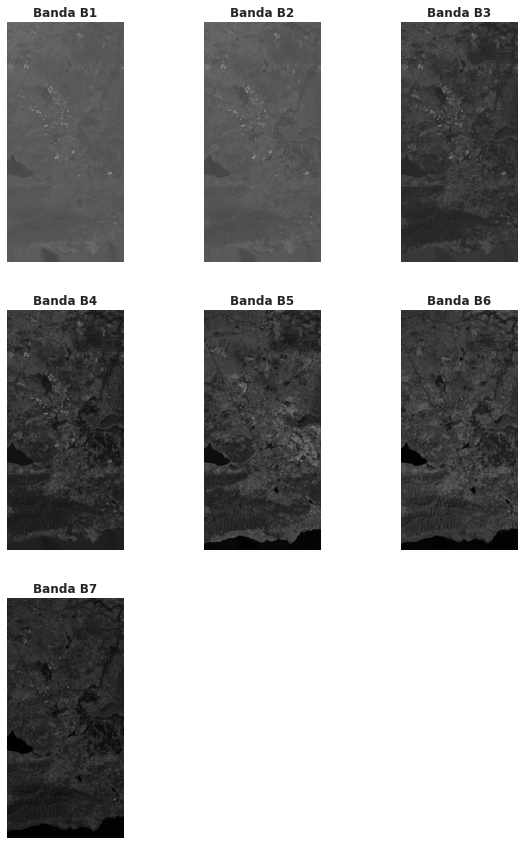

In [6]:
# Vamos a mostrar las imágenes de satélite por cada banda
sns.set(style="white")
fig = plt.figure(figsize=(10, 15))
for i in range(1, len(labels) + 1 ):
    ax = fig.add_subplot(3, 3, i)
    show(arr_img[:,:,i-1], cmap='Greys_r', ax=ax, title=f"Banda {labels[i-1]}")
    plt.axis('off')

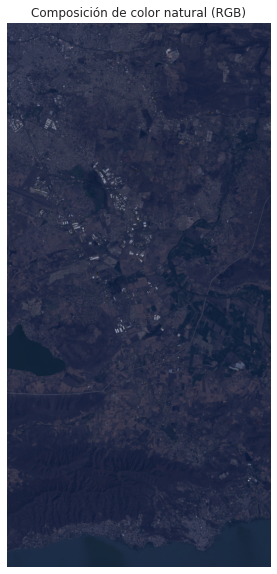

In [7]:
# Ahora veamos cómo obtener una imagen de color natural con las bandas RGB

# Normalizamos las bandas en escala de 0.0 - 1.0
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

# Seleccionamos los array que corresponde a cada banda 
red = arr_img[:,:,3]
green = arr_img[:,:,2]
blue = arr_img[:,:,1]

# Normalizamos con la función 
red_norm = normalize(red)
green_norm = normalize(green)
blue_norm = normalize(blue)

# Realizamos el Stack
rgb = np.dstack((red_norm, green_norm, blue_norm))

# Vemos la composición de color
fig = plt.figure(figsize=(5, 10))
plt.imshow(rgb)
plt.title("Composición de color natural (RGB)")
plt.axis('off');

### **II.I. Análisis exploratorio de datos (EDA)**

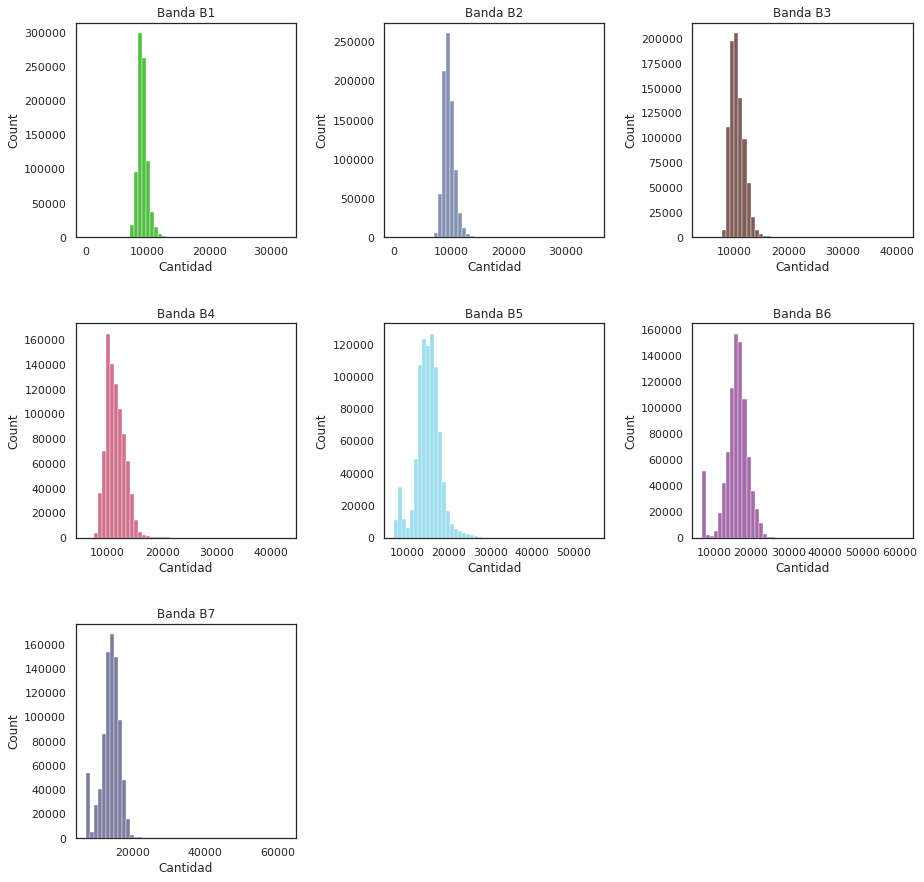

In [8]:
# Ahora analizaremos los histogramas.

fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(1, len(labels) + 1): #
    ax = fig.add_subplot(3, 3, i)
    sns.histplot(arr_img[:,:,i-1].flatten(),
                 color=np.random.rand(3,), bins = 50)
    ax.set_title(f"Banda {labels[i-1]}")
    ax.set(xlabel="Cantidad")

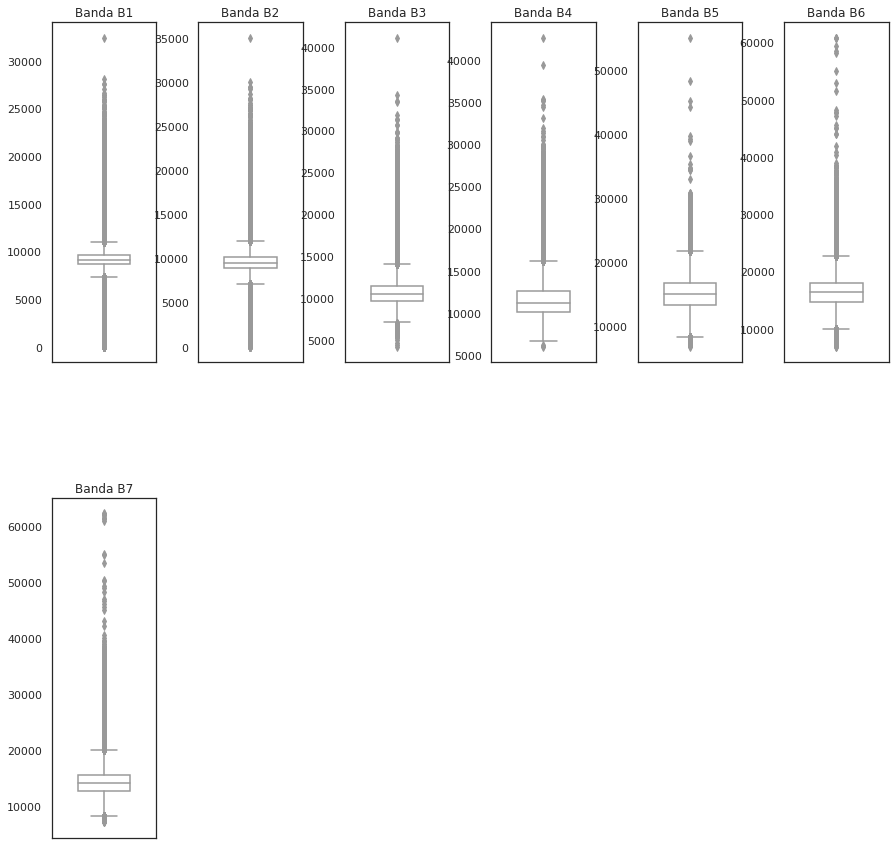

In [9]:
# Veamos los bloxplots

fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(1, len(labels) + 1 ):
    ax = fig.add_subplot(2, 6, i)
    sns.boxplot(y=arr_img[:,:,i-1].flatten(),
                color='white', width=.5)
    ax.set_title(f"Banda {labels[i-1]}")

plt.show()

### **II.II. Estandarización**

Dentro de este apartado realizaremos una estandarización de los datos moviendo la media a 0 y la desviación estandar a la unidad.

In [10]:
# Cargamos nuestra librería
from sklearn.preprocessing import StandardScaler

# Hacemos un reshape para dividir todos los datos de forma lineal, en cada una de las bandas
X_data = arr_img.reshape(-1, 7)

# Realizamos la estandarización
scaler = StandardScaler().fit(X_data)
X_estan = scaler.transform(X_data)
print(f"La nueva dimensión del array es {X_estan.shape}")
1328 * 643


La nueva dimensión del array es (853904, 7)


853904

## **III. Algoritmos no supervisados de Machine Learning**

### **III.I. Clasificación no supervisada: PCA y K-Means Clustering**

En este apartado veremos los resultados que obtenemos a partir de una clasificación no supervisada.

Usaremos el analisis de componentes principales (PCA), así como el método del inercia para poder encontrar el número de componentes que explican la mayor varianza de los datos.

Igualmente, emplearemos la clasificación K-Means Clustering para identificar los conglomerados a partir de los cuales se puede clasificar la imagen de satélite.

In [11]:
%%time

from sklearn.decomposition import PCA

# Análisis de componentes principales, usando los datos previamente preprocesados
pca = PCA(n_components = 6)

pca.fit(X_estan)

data_pca = pca.transform(X_estan)

print("La varianza explicada en cada componente principal es:")
for i in range(0, len(pca.explained_variance_ratio_)):
    print(f"PCA{i+1} = {pca.explained_variance_ratio_[i]}")
print(f"El total de la varianza dentro de las componentes es:\n {np.sum(pca.explained_variance_ratio_)}")

La varianza explicada en cada componente principal es:
PCA1 = 0.7516032502938785
PCA2 = 0.15634839507842674
PCA3 = 0.06986837797460513
PCA4 = 0.01543344511076625
PCA5 = 0.0036784915044556048
PCA6 = 0.0019617267815460336
El total de la varianza dentro de las componentes es:
 0.9988936867436784
CPU times: user 394 ms, sys: 223 ms, total: 617 ms
Wall time: 559 ms


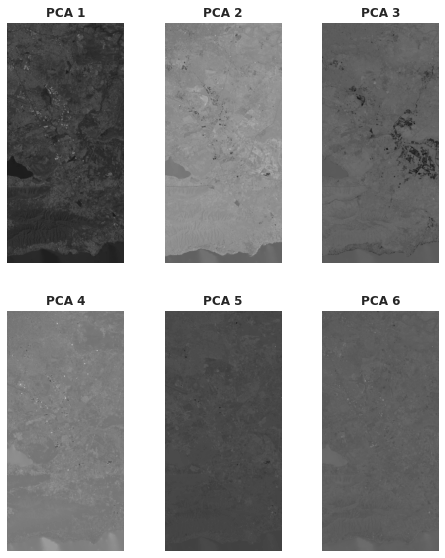

In [12]:
# Vamos a hacer un plot de nuestras PCA
# Primero realizaremos un reshape para regresarlos a la misma 
# forma que los datos originales, y que tengan la misma dimensiones

data_pca_reshape = data_pca.reshape((1328, 643, data_pca.shape[1]))

# Loop para visualizar nuestras componentes
fig = plt.figure(figsize=(8, 15))
for i in range(1, 6+ 1 ):
    ax = fig.add_subplot(3, 3, i)
    show(data_pca_reshape[:,:,i-1], cmap='Greys_r', ax=ax, title=f"PCA {i}")
    plt.axis('off')

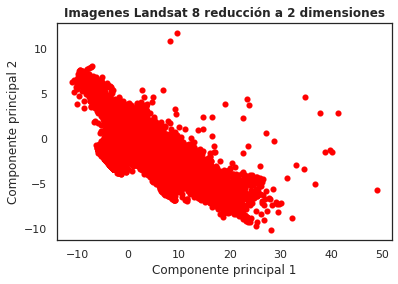

In [13]:
# Ahora graficaremos nuestras dos primeros componentes 

plt.scatter(x=data_pca_reshape[:,:,0], y=data_pca_reshape[:,:,1], color='red',lw=0.1)
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.title('Imagenes Landsat 8 reducción a 2 dimensiones',fontweight='bold')
plt.show()

In [14]:
# Inercia
import sklearn.cluster as cluster
from tqdm import tqdm

inertia = []
for i in tqdm(range(2,12)):
    kmeans = cluster.KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=50)
    kmeans.fit(data_pca)
    inertia.append(kmeans.inertia_)

100%|██████████| 10/10 [09:31<00:00, 57.12s/it]


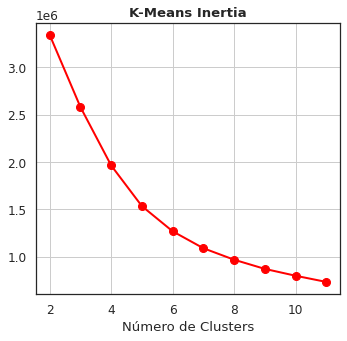

In [15]:
# Finalmente realizamos el plot
sns.set(style='white',font_scale=1.1, rc={'figure.figsize':(12,5)})

plt.subplot(1, 2, 1)

plt.plot(range(2,len(inertia)+2), inertia, marker='o',lw=2,ms=8,color='red')
plt.xlabel('Número de Clusters')
plt.title('K-Means Inertia',fontweight='bold')
plt.grid(True)

A partir de la gráfica anterior, encontramos que debemos realzar la clasificación en 6 componentes. A continuación usaremos el método de k-means para realizar la clasificación.  

Es importante mencionar que esta clasificación sera usada como los "reales del terreno", es decir **y_data**, para poder analizar los algoritmos de Machine learning y así conocer su precisión.

In [16]:
%%time
# Ahora vamos a realizar nuestra clasificación

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=25, init="k-means++")

kmeans.fit(data_pca)

clasificacion = kmeans.predict(data_pca)

CPU times: user 26 s, sys: 2.45 s, total: 28.5 s
Wall time: 25.6 s


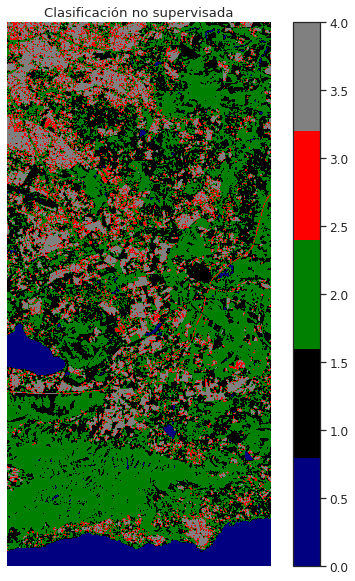

In [17]:
# Veamos nuestros resultados

class_color = ListedColormap(['navy', 'black', 'green', 'red', "grey"])

plt.figure(figsize=(8, 10))
plt.imshow(clasificacion.reshape(1328, 643), cmap=class_color)
plt.title("Clasificación no supervisada")
plt.colorbar()
plt.axis('off');

In [18]:
# Ahora usaremos esta clasificación como "y_data"

y_data = clasificacion

## **IV. Conjuntos de entrenamiento y prueba**

### **IV.I Separación, validación y evaluación para algoritmos de ML**

En esta etapa, realizaremos la separación del dataset entre conjunto de entrenamiento y conjunto de prueba, para clasificar nuestras imágenes.

In [19]:
# Ahora a dividir nuestro array con las imágenes 
from sklearn.model_selection import train_test_split

# Es importante usar el .ravel() pues de esta forma nuestro array tendrá las 
# mismas dimensiones al array con las 12 imágenes de satélite
X_train, X_test, y_train, y_test = train_test_split(X_estan, y_data.ravel(), 
                                  test_size=0.30, stratify = y_data.ravel(), random_state=50)
print(f'Dimensiones X_train: {X_train.shape}\nDimensión X_test: {X_test.shape}\nDimensión y_train: {y_train.shape}\nDimensión y_test:{y_test.shape}')

Dimensiones X_train: (597732, 7)
Dimensión X_test: (256172, 7)
Dimensión y_train: (597732,)
Dimensión y_test:(256172,)


## **V. Algoritmos supervisados de Machine Learning**

### **V.I. Clasificación supervisada: K-Nearest Neighbor Classifier (K-NNC)**

En esta sección aplicamos el algoritmo de clasificación de vecino más próximo (K-NNC), para asignar los datos en grupos, con base en una casificación de puntos dada. 

In [143]:
%%time

tic = time()

# Importamos la librería
from sklearn.neighbors import KNeighborsClassifier

# Hacemos el modelo con 6 clusters, que son los valores clasificados del terreno
knn = KNeighborsClassifier(n_neighbors=6)

# Obtenemos el fit entre los datos de entrenamiento
knn.fit(X_train, y_train)

# Hacemos predicciones
knn_pred = knn.predict(X_test)

toc = time()

t_knn = toc - tic

CPU times: user 36 s, sys: 127 ms, total: 36.1 s
Wall time: 35.9 s


In [144]:
t_knn

35.924633264541626

In [158]:
# Importamos y calculamos las métricas
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score

precision_knn = np.mean(precision_score(y_test, knn_pred, average=None)*100)
exactitud_knn = accuracy_score(y_test, knn_pred)*100
sensibilidad_knn = np.mean(recall_score(y_test, naiv_pred, average=None)*100)

#imprimimos las métricas
print(f"Precisión PPV: {precision_knn:.3f}")
print(f"Exactitud ACC: {exactitud_knn:.3f}")
print(f"Sensibilidad TPR: {sensibilidad_knn:.3f}")

# Realizamos el reporte de clasificación
print(classification_report(y_test, knn_pred))

Precisión PPV: 99.087
Exactitud ACC: 99.256
Sensibilidad TPR: 96.708
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17794
           1       0.99      1.00      0.99     92138
           2       1.00      0.99      0.99     91426
           3       0.98      0.99      0.98      1632
           4       1.00      0.99      0.99     53182

    accuracy                           0.99    256172
   macro avg       0.99      0.99      0.99    256172
weighted avg       0.99      0.99      0.99    256172



CPU times: user 1min 34s, sys: 345 ms, total: 1min 35s
Wall time: 1min 34s


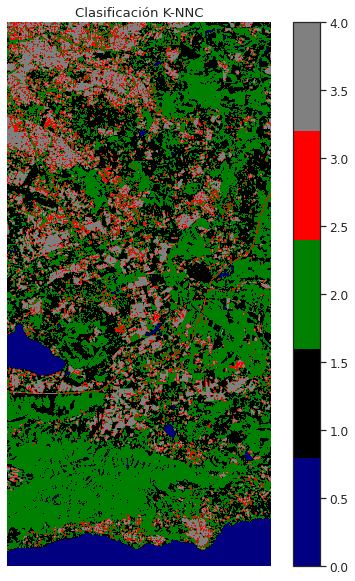

In [157]:
%%time

# Vamos a ver nuestros resultados

plt.figure(figsize=(8, 10))
plt.imshow(knn.predict(X_estan).reshape((1328, 643)), cmap=class_color) #
plt.title("Clasificación K-NNC")
plt.colorbar()
plt.axis('off');

### **V.II. Clasificación supervisada: Árboles de decisión**

Ahora usaremos arboles de decisión (Decision Trees) para observar cómo nuestra clasificación puede variar o no de los datos del terreno. De igual forma, analizar el tiempo de cómputo requerido para esta clasificación.

In [159]:
%%time

tic = time()

# Importamos la librería
from sklearn.tree import DecisionTreeClassifier

# Agregamos el modelo
dtc = DecisionTreeClassifier()

# Realizamos nuestra clasificación usando los datos de entrenamiento
dtc = dtc.fit(X_train, y_train)

# Predicción en los datos de prueba
dtc_pred = dtc.predict(X_test)

toc = time()

t_dtc = toc - tic

CPU times: user 10.1 s, sys: 6.72 ms, total: 10.2 s
Wall time: 10.1 s


In [161]:
t_dtc

10.12155032157898

In [166]:
#calculamos las métricas

precision_dtc = np.mean(precision_score(y_test, dtc_pred, average=None)*100)
exactitud_dtc = accuracy_score(y_test, dtc_pred)*100
sensibilidad_dtc = np.mean(recall_score(y_test, dtc_pred, average=None)*100)

#imprimimos las métricas
print(f"Precisión PPV: {precision_dtc:.3f}")
print(f"Exactitud ACC: {exactitud_dtc:.3f}")
print(f"Sensibilidad TPR: {sensibilidad_dtc:.3f}")

# Realizamos el reporte de clasificación
print(classification_report(y_test, dtc_pred))

Precisión PPV: 98.168
Exactitud ACC: 98.170
Sensibilidad TPR: 98.144
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17794
           1       0.98      0.98      0.98     92138
           2       0.99      0.99      0.99     91426
           3       0.97      0.97      0.97      1632
           4       0.98      0.98      0.98     53182

    accuracy                           0.98    256172
   macro avg       0.98      0.98      0.98    256172
weighted avg       0.98      0.98      0.98    256172



CPU times: user 328 ms, sys: 11.6 ms, total: 339 ms
Wall time: 346 ms


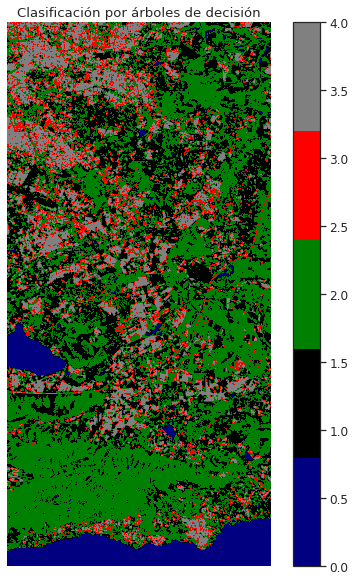

In [25]:
%%time

# Vamos a ver nuestros resultados, y la clasificación de todos los datos

plt.figure(figsize=(8, 10))
plt.imshow(dtc.predict(X_estan).reshape((1328, 643)), cmap=class_color) #
plt.title("Clasificación por árboles de decisión")
plt.colorbar()
plt.axis('off');

#### **V.II.I. Árboles de decisión: Random Forest**

De manera similar, ahora usaremos el Random Forest para analizar nuestra clasificación.

In [172]:
%%time

tic = time()

# Importamos la librería
from sklearn.ensemble import RandomForestClassifier

# Agregamos el modelo
rfc = RandomForestClassifier()

# Realizamos nuestra clasificación usando los datos de entrenamiento
rfc = rfc.fit(X_train, y_train)

# Predicción en los datos de prueba
rfc_pred = rfc.predict(X_test)

toc = time()

t_rfc = toc - tic

CPU times: user 4min 19s, sys: 324 ms, total: 4min 19s
Wall time: 4min 18s


In [173]:
t_rfc

258.75610280036926

In [174]:
# Calculamos las métricas

precision_rfc = np.mean(precision_score(y_test, rfc_pred, average=None)*100)
exactitud_rfc = accuracy_score(y_test, rfc_pred)*100
sensibilidad_rfc = np.mean(recall_score(y_test, rfc_pred, average=None)*100)

#imprimimos las métricas
print(f"Precisión PPV: {precision_rfc:.3f}")
print(f"Exactitud ACC: {exactitud_rfc:.3f}")
print(f"Sensibilidad TPR: {sensibilidad_rfc:.3f}")

# Realizamos el reporte de clasificación
print(classification_report(y_test, rfc_pred))

Precisión PPV: 99.262
Exactitud ACC: 99.276
Sensibilidad TPR: 99.090
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17794
           1       0.99      0.99      0.99     92138
           2       0.99      0.99      0.99     91426
           3       0.99      0.98      0.98      1632
           4       0.99      0.99      0.99     53182

    accuracy                           0.99    256172
   macro avg       0.99      0.99      0.99    256172
weighted avg       0.99      0.99      0.99    256172



CPU times: user 12.7 s, sys: 70.5 ms, total: 12.8 s
Wall time: 12.8 s


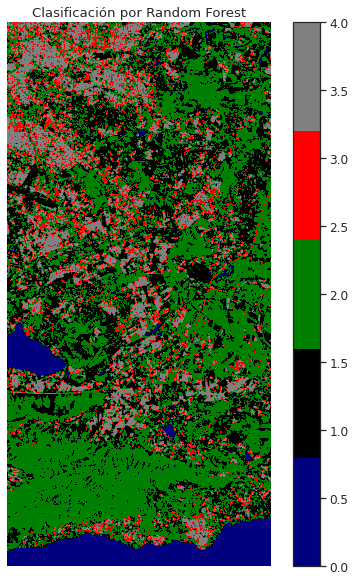

In [28]:
%%time

# Vamos a ver nuestros resultados, y la clasificación de todos los datos

plt.figure(figsize=(8, 10))
plt.imshow(rfc.predict(X_estan).reshape((1328, 643)), cmap=class_color) #
plt.title("Clasificación por Random Forest")
plt.colorbar()
plt.axis('off');

#### **V.II.II. Árboles de decisión: Decision Tree Regression**

En esta parte, aplicamos un modelo de clasificación en forma de estructura de árbol de decisión.

In [175]:
%%time

tic = time()

# importamos el Decision Tree Regresion
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()

# Realizamos nuestra clasificación usando los datos de entrenamiento
dtr = dtr.fit(X_train, y_train)

# Predicción en los datos de prueba
dtr_pred = dtr.predict(X_test)

toc = time()

t_dtr = toc - tic

CPU times: user 9.12 s, sys: 10.2 ms, total: 9.13 s
Wall time: 9.09 s


In [176]:
t_dtr

9.092992782592773

In [177]:
# Calculamos las métricas

precision_dtr = np.mean(precision_score(y_test, dtr_pred, average=None)*100)
exactitud_dtr = accuracy_score(y_test, dtr_pred)*100
sensibilidad_dtr = np.mean(recall_score(y_test, dtr_pred, average=None)*100)

#imprimimos las métricas
print(f"Precisión PPV: {precision_dtr:.3f}")
print(f"Exactitud ACC: {exactitud_dtr:.3f}")
print(f"Sensibilidad TPR: {sensibilidad_dtr:.3f}")

# Realizamos el reporte de clasificación
print(classification_report(y_test, dtr_pred))

Exactitud: 98.180
Precisión PPV: 98.167
Exactitud ACC: 98.180
Sensibilidad TPR: 98.192
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17794
           1       0.98      0.98      0.98     92138
           2       0.99      0.99      0.99     91426
           3       0.97      0.97      0.97      1632
           4       0.98      0.98      0.98     53182

    accuracy                           0.98    256172
   macro avg       0.98      0.98      0.98    256172
weighted avg       0.98      0.98      0.98    256172



CPU times: user 129 ms, sys: 883 µs, total: 130 ms
Wall time: 131 ms


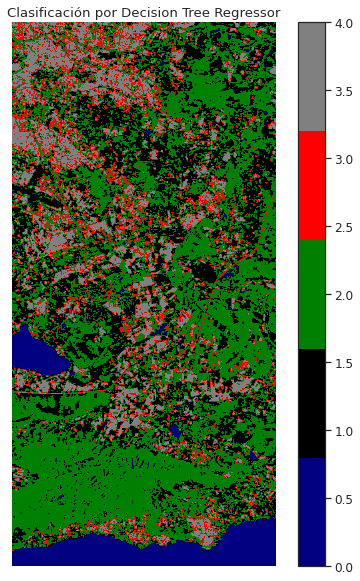

In [31]:
%%time

# Vamos a ver nuestros resultados, y la clasificación de todos los datos

plt.figure(figsize=(8, 10))
plt.imshow(dtr.predict(X_estan).reshape((1328, 643)), cmap=class_color) #
plt.title("Clasificación por Decision Tree Regressor")
plt.colorbar()
plt.axis('off');

#### **V.II.III. Árboles de decisión: Decision Tree Regression con AdaBoost**

Este algoritmo funciona de la misma forma que el anterior, pero tiene diferentes estimadores, es decir, usa más árboles de decisión (boosts) para que la regresión se ajuste con mayor detalle.

In [178]:
%%time

tic = time()

# Importamos AdaBoost
from sklearn.ensemble import AdaBoostRegressor

# Usaremos un modelo con 200 árboles de decisión
adtr = AdaBoostRegressor(DecisionTreeRegressor(), n_estimators=50, random_state=25)

# Realizamos nuestra clasificación usando los datos de entrenamiento
adtr = adtr.fit(X_train, y_train)

# Predicción en los datos de prueba
adtr_pred = adtr.predict(X_test)

toc = time()

t_adtr = toc - tic

CPU times: user 3min 28s, sys: 253 ms, total: 3min 28s
Wall time: 3min 27s


In [179]:
t_adtr

207.33934569358826

In [181]:
# Calculamos las métricas
precision_adtr = np.mean(precision_score(y_test, adtr_pred, average=None)*100)
exactitud_adtr = accuracy_score(y_test, adtr_pred)*100
sensibilidad_adtr = np.mean(recall_score(y_test, adtr_pred, average=None)*100)

#imprimimos las métricas
print(f"Precisión PPV: {precision_adtr:.3f}")
print(f"Exactitud ACC: {exactitud_adtr:.3f}")
print(f"Sensibilidad TPR: {sensibilidad_adtr:.3f}")

# Realizamos el reporte de clasificacion
print(classification_report(y_test, adtr_pred))

Precisión PPV: 99.369
Exactitud ACC: 99.367
Sensibilidad TPR: 99.236
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17794
           1       0.99      0.99      0.99     92138
           2       1.00      1.00      1.00     91426
           3       0.99      0.98      0.99      1632
           4       0.99      0.99      0.99     53182

    accuracy                           0.99    256172
   macro avg       0.99      0.99      0.99    256172
weighted avg       0.99      0.99      0.99    256172



CPU times: user 5.7 s, sys: 312 ms, total: 6.01 s
Wall time: 5.98 s


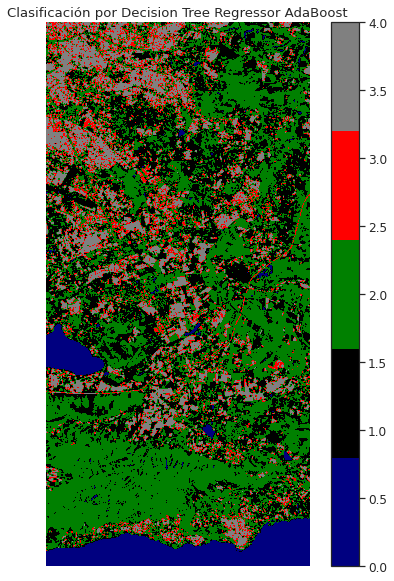

In [34]:
%%time

# Vamos a ver nuestros resultados, y la clasificación de todos los datos

plt.figure(figsize=(8, 10))
plt.imshow(adtr.predict(X_estan).reshape((1328, 643)), cmap=class_color) #
plt.title("Clasificación por Decision Tree Regressor AdaBoost")
plt.colorbar()
plt.axis('off');

### **V.III. Clasifiación supervisada: Redes Neuronales Artificiales**

En esta parte, realizamos una red neuronal artificial a partir de un perceptrón multicapa (MLPC) que clasifica a partir de umbrales de activación.

In [190]:
%%time

tic = time()

# Importamos la librería
from sklearn.neural_network import MLPClassifier

# Agregamos el modelo
ann = MLPClassifier(hidden_layer_sizes=(4,2),
                            max_iter=1000,
                            activation ='relu',
                            tol= 0.0001)

# Realizamos nuestra clasificación usando los datos de entrenamiento
ann = ann.fit(X_train, y_train)

# Predicción en los datos de prueba
ann_pred = ann.predict(X_test)

toc = time()

t_ann = toc - tic

CPU times: user 1min 14s, sys: 274 ms, total: 1min 14s
Wall time: 1min 14s


In [196]:
t_ann

74.58247113227844

In [195]:
#Calculamos las métricas: 

precision_ann = np.mean(precision_score(y_test, ann_pred, average=None)*100)
exactitud_ann = accuracy_score(y_test, ann_pred)*100
sensibilidad_ann = np.mean(recall_score(y_test, ann_pred, average=None)*100)

#imprimimos las métricas
print(f"Precisión PPV: {precision_ann:.3f}")
print(f"Exactitud ACC: {exactitud_ann:.3f}")
print(f"Sensibilidad TPR: {sensibilidad_ann:.3f}")

# Realizamos el reporte de clasificación
print(classification_report(y_test, ann_pred))

Precisión PPV: 99.426
Exactitud ACC: 99.785
Sensibilidad TPR: 98.825
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     17794
           1       1.00      1.00      1.00     92138
           2       1.00      1.00      1.00     91426
           3       0.98      0.96      0.97      1632
           4       1.00      1.00      1.00     53182

    accuracy                           1.00    256172
   macro avg       0.99      0.99      0.99    256172
weighted avg       1.00      1.00      1.00    256172



CPU times: user 413 ms, sys: 132 ms, total: 545 ms
Wall time: 364 ms


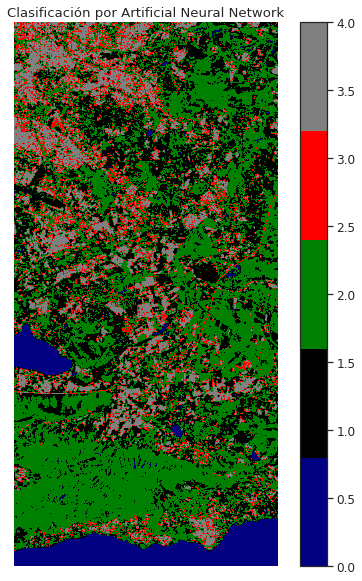

In [37]:
%%time

# Vamos a ver nuestros resultados, y la clasificación de todos los datos

plt.figure(figsize=(8, 10))
plt.imshow(ann.predict(X_estan).reshape((1328, 643)), cmap=class_color) #
plt.title("Clasificación por Artificial Neural Network")
plt.colorbar()
plt.axis('off');

### **V.IV. Clasifiación supervisada: Maquina de Soporte Vectorial**

Siguiendo con los modelos de clasificación, ahora se realiza una clasificación de los umbrales por medio de una SVM. 





In [197]:
%%time 

tic = time()

#importo el modelo de Sklearn: 
from sklearn.svm import SVC #Support Vector Classifier

#agrego el modelo: 

modelo_SVC = SVC()

# Realizamos nuestra clasificación usando los datos de entrenamiento


svc = modelo_SVC.fit(X_train, y_train)

# Predicción en los datos de prueba
svc_pred = entrenamiento.predict(X_test)

toc = time()

t_svc = toc - tic

CPU times: user 10min 28s, sys: 896 ms, total: 10min 29s
Wall time: 10min 26s


In [198]:
t_svc

626.5310490131378

In [200]:
#Calculamos las métricas:

precision_svc = np.mean(precision_score(y_test, svc_pred, average=None)*100)
exactitud_svc = accuracy_score(y_test, svc_pred)*100
sensibilidad_svc = np.mean(recall_score(y_test, svc_pred, average=None)*100)

#imprimimos las métricas
print(f"Precisión PPV: {precision_svc:.3f}")
print(f"Exactitud ACC: {exactitud_svc:.3f}")
print(f"Sensibilidad TPR: {sensibilidad_svc:.3f}")

# Realizamos el reporte de clasificación
print(classification_report(y_test, prediccion))

Precisión PPV: 99.859
Exactitud ACC: 99.939
Sensibilidad TPR: 99.822
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17794
           1       1.00      1.00      1.00     92138
           2       1.00      1.00      1.00     91426
           3       1.00      0.99      0.99      1632
           4       1.00      1.00      1.00     53182

    accuracy                           1.00    256172
   macro avg       1.00      1.00      1.00    256172
weighted avg       1.00      1.00      1.00    256172



CPU times: user 7min 45s, sys: 340 ms, total: 7min 46s
Wall time: 7min 44s


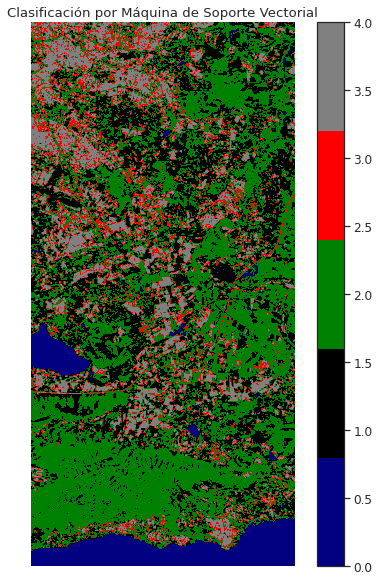

In [41]:
%%time 
# Visualizamos nuestros resultados: 

plt.figure(figsize=(8, 10))
plt.imshow(entrenamiento.predict(X_estan).reshape((1328, 643)), cmap=class_color) 
plt.title("Clasificación por Máquina de Soporte Vectorial")
plt.colorbar()
plt.axis('off');

### **V.V. Clasifiación supervisada: Naïve Bayes**

In [201]:
%%time

tic = time()

#importo el modelo Naïve Bayes
from sklearn.naive_bayes import GaussianNB

naiv = GaussianNB()

naiv_fit = naiv.fit(X_train, y_train)

naiv_pred = naiv_fit.predict(X_test)

toc = time()

t_naiv = toc - tic

CPU times: user 300 ms, sys: 1.95 ms, total: 302 ms
Wall time: 303 ms


In [202]:
t_naiv

0.30333924293518066

In [204]:
#Calculamos las métricas

precision_naiv = np.mean(precision_score(y_test, naiv_pred, average=None)*100)
exactitud_naiv = accuracy_score(y_test, naiv_pred)*100
sensibilidad_naiv = np.mean(recall_score(y_test, naiv_pred, average=None)*100)

#imprimimos las métricas
print(f"Precisión PPV: {precision_naiv:.3f}")
print(f"Exactitud ACC: {exactitud_naiv:.3f}")
print(f"Sensibilidad TPR: {sensibilidad_naiv:.3f}")

# Realizamos el reporte de clasificación
print(classification_report(y_test, naiv_pred))

Precisión PPV: 88.645
Exactitud ACC: 96.240
Sensibilidad TPR: 96.708
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     17794
           1       0.98      0.94      0.96     92138
           2       0.97      0.98      0.97     91426
           3       0.55      1.00      0.71      1632
           4       0.94      0.98      0.96     53182

    accuracy                           0.96    256172
   macro avg       0.89      0.97      0.91    256172
weighted avg       0.97      0.96      0.96    256172



CPU times: user 296 ms, sys: 4.1 ms, total: 300 ms
Wall time: 303 ms


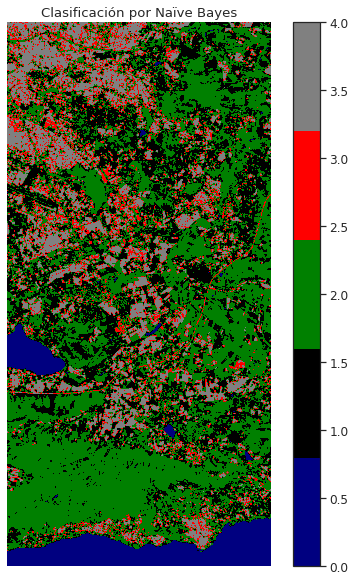

In [44]:
%%time 
# Visualizamos nuestros resultados: 

plt.figure(figsize=(8, 10))
plt.imshow(naiv_fit.predict(X_estan).reshape((1328, 643)), cmap=class_color) #
plt.title("Clasificación por Naïve Bayes")
plt.colorbar()
plt.axis('off');

## Eficiencia 

Ahora que hemos realizado distintas clasificaciones para el terreno, algo que resulta importante es analizar qué método de clasificación es el que brinda mejores resultados. Recordemos que el mejor método para hacer estas clasificaciones resultaría en el que entrega mejores predicciones con respecto a exactitud y precisión con respecto al tiempo de cálculo. 

In [210]:
tiempos = np.array([t_knn, t_dtc, t_dtr, t_adtr, t_ann, t_svc, t_naiv])
presicion = np.array([precision_knn, precision_dtc, precision_dtr, precision_adtr, precision_ann, precision_svc, precision_naiv])
exactitud = np.array([exactitud_knn, exactitud_dtc, precision_dtr, exactitud_adtr, exactitud_ann, exactitud_svc, exactitud_naiv])

In [218]:
eficiencia = {'tiempo':tiempos, 'precision':presicion, 'exactitud':exactitud}

In [220]:
eficiencia = pd.DataFrame(dicc).sort_values(by = 'tiempo').reset_index(drop = True)

eficiencia

,tiempo,precision,exactitud
0,0.303339,88.644953,96.239636
1,9.092993,98.166556,98.166556
2,10.121550,98.168062,98.169589
3,35.924633,99.086526,99.256359
4,74.582471,99.426027,99.784910
5,207.339346,99.369232,99.366832
6,626.531049,99.859025,99.939494
